# Back to the Future : Time Travelling through Wikispeedia

## Part 0 : Preprocessing of data

#### Setting the environment 
Please check SETUP.md and pip_requirements.txt before running this notebook.

In [1]:
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import os

from src.scripts.loading_data import *
from src.scripts.plotting import *

from src.utils.data_utils import *
from src.utils.llm_plot import *
from src.utils.llm_metric import *
from src.utils.llm_processing import *

In [2]:
# Define consant
DATA = "data/"

Some definitions:
- source article: the initial point of a game
- target article: the final point that players are looking for.
- path: all the articles visited by the player during his/her game, including the source and target articles (if the latter is found)


## Part 1 : Factors of success in Wikispeedia 2007

### 1.0) Introduction
The start point of our journey is situated in the past, in 2007. We investigate possible reasons of failure at the Wikispeedia game on articles from 2007. For this purpose, we use the dataset furnished [1][2].


### 1.1) Exploring categories
The categories of the articles are given in the `categories.tsv` file.

#### 1.1.1) Cleaning the categories

In [ ]:
articles2007, links2007 = loading_articles_links('2007')

categories = loading_cleaned_categories()
print(f'Shape of categories df: {categories.shape}, number of unique articles in categories.tsv: {categories.index.unique().shape}, number of articles in articles.tsv: {articles2007.article_2007.unique().shape}')

Shape of categories df: (5204, 3), number of unique articles in categories.tsv: (5204,), number of articles in articles.tsv: (4604,)


Wait a minute... There is more rows in categories than the number of articles. Some articles have more than 1 category! In addition, there are less unique appearance of articles than the total number of articles in `articles.tsv`! We want to fix that for our Sankey diagram. First let's find the 6 articles missing in `categories.tsv`.

In [ ]:
articles_not_in_categories = art_not_in_cat(articles2007, categories, 'article_2007')
articles_not_in_categories

array(['Directdebit', 'Donation', 'Friend_Directdebit', 'Pikachu',
       'Sponsorship_Directdebit', 'Wowpurchase'], dtype=object)

We got them. Let's keep them here for later, it might be useful. Now let's deal with articles having several categories. First, let's find them.

In [ ]:
categories.article.value_counts().value_counts()

count
1    4000
2     590
3       8
Name: count, dtype: int64

4000 articles have only 1 category, 590 have 2 categories and 8 of them have 3 categories.

In [ ]:
categories_duplicated = categories.loc[categories.index.duplicated(keep=False)]
categories_duplicated

,article,category,main_category


In [ ]:
categories.loc[categories[['article', 'main_category']].duplicated(keep=False)]

,article,category,main_category
177,Al_Jazeera,"[Citizenship, Media]",Citizenship
178,Al_Jazeera,"[Citizenship, Politics_and_government]",Citizenship
205,Alfred_the_Great,"[People, Military_People]",People
206,Alfred_the_Great,"[People, Monarchs_of_Great_Britain]",People
297,Animation,"[Everyday_life, Computer_and_Video_games]",Everyday_life
...,...,...,...
5046,Whipworm,"[Science, Biology, Organisms]",Science
5051,White_cliffs_of_Dover,"[Geography, Geography_of_Great_Britain]",Geography
5052,White_cliffs_of_Dover,"[Geography, Geology_and_geophysics]",Geography
5068,William_Ewart_Gladstone,"[People, Historical_figures]",People


We notice that some articles have the same main category but the subcategories are different. Let's focus on the main category and get rid off the other subcategories. We keep delete one the duplicated main category for every concerned article. 

In [ ]:
categories = categories.drop(index=categories.loc[categories[['article', 'main_category']].duplicated()].index)
categories

,article,category,main_category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[History, British_History, British_History_150...",History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[People, Historical_figures]",People
2,%C3%85land,[Countries],Countries
3,%C3%85land,"[Geography, European_Geography, European_Count...",Geography
4,%C3%89douard_Manet,"[People, Artists]",People
...,...,...,...
5199,Zirconium,"[Science, Chemistry, Chemical_elements]",Science
5200,Zoroaster,"[People, Religious_figures_and_leaders]",People
5201,Zuid-Gelders,"[Geography, European_Geography]",Geography
5202,Zuid-Gelders,"[Language_and_literature, Languages]",Language_and_literature


In [ ]:
# let's check if this problem is solved, i.e. this command return an empty df
categories.loc[categories[['article', 'main_category']].duplicated(keep=False)]

,article,category,main_category


In [ ]:
# update the df containing only duplicated articles. We have deleted 90 useless rows. 
categories_duplicated = categories.loc[categories.article.duplicated(keep=False)]
categories_duplicated

,article,category,main_category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[History, British_History, British_History_150...",History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[People, Historical_figures]",People
2,%C3%85land,[Countries],Countries
3,%C3%85land,"[Geography, European_Geography, European_Count...",Geography
5,%C3%89ire,[Countries],Countries
...,...,...,...
5193,Zimbabwe,[Countries],Countries
5197,Zionism,"[People, Political_People]",People
5198,Zionism,"[Religion, Religious_movements_traditions_and_...",Religion
5201,Zuid-Gelders,"[Geography, European_Geography]",Geography


It looks better, but we still have 1013 rows to sort out. From now on, we will do purely arbitrary choices to keep only one main category.
You can find the logical reasoning and examples of paths concerned in `categories_partial_ordering.md`. Using this partial ordering, we can kick out the duplicated articles we do not want.

In [ ]:

relationships = [('History', 'People'), ('Religion', 'People'), ('Language_and_literature', 'People'),
 ('Science', 'People'), ('Religion', 'History'), ('Countries', 'Geography'), ('Language_and_literature', 'Geography'), 
 ('Language_and_literature', 'Design_and_Technology'), ('Language_and_literature', 'History'), ('Science', 'Everyday_life'), 
 ('Science', 'Design_and_Technology'), ('Geography', 'Design_and_Technology'), ('History', 'Design_and_Technology'), 
 ('Mathematics', 'Everyday_life'), ('Everyday_life', 'People'), ('Everyday_life', 'History'), ('History', 'Geography'),
 ('Geography', 'Citizenship'), ('Design_and_Technology', 'Citizenship'), ('Design_and_Technology', 'Everyday_life'),
 ('Science', 'Citizenship'), ('Business_Studies', 'IT'), ('Business_Studies', 'Geography'), ('Business_Studies', 'People'),
 ('Citizenship', 'Everyday_life'), ('Business_Studies', 'Everyday_life'), ('Everyday_life', 'People'), ('Science', 'IT'),
 ('Geography', 'Everyday_life'), ('Geography', 'Science'), ('Business_Studies', 'History'), ('History', 'Citizenship'),
 ('Science', 'History'), ('Science', 'Business_Studies'), ('Art', 'Everyday_life'), ('Art', 'Business_Studies'),
 ('Art', 'Design_and_Technology'), ('Music', 'History'), ('Religion', 'Citizenship'), ('IT', 'Design_and_Technology'),
 ('IT', 'Citizenship'), ('Business_Studies', 'Citizenship'), ('Art', 'History'), ('IT', 'History'), 
 ('Science', 'Religion'), ('Language_and_literature', 'Art'), ('Design_and_Technology', 'People')]

categories, categories_duplicated = delete_duplicates_cat(categories, relationships)

print(f'Number of unique article names in categories: {categories.article.unique().size}, number of rows: {categories.article.size}.')

categories = categories.set_index('article') # easier for the following

display(categories_duplicated) # is empty, as expected

Number of unique article names in categories: 4598, number of rows: 4598.


,article,category,main_category


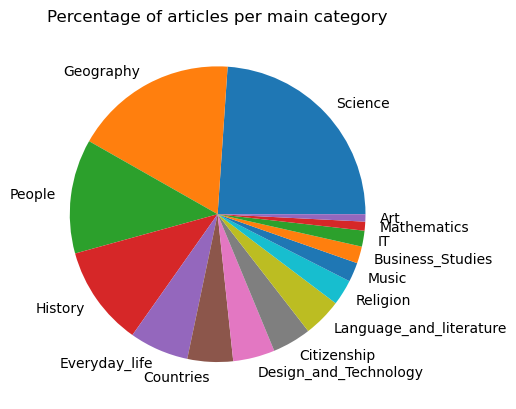

In [ ]:
# NEXTSTEP:: make it pretty
plt.pie(categories.main_category.value_counts(), labels=categories.main_category.value_counts().index)
plt.title('Percentage of articles per main category');
# plt.legend()

#### 1.1.2) Links and categories

Now each article has only one category assigned. We can thus work with the categories. First, let's analyse where links present in an article of a given category send the player: in the same category, or in another one?


In [ ]:
# have to check that the articles present in the links.tsv are in categories.tsv

# retrieve all the article names present in links.tsv
articles_names_from_links = list(links2007.linkSource.unique()) + list(links2007.linkTarget.unique())

# keep 1 occurence per name only
articles_names_from_links = pd.DataFrame.from_dict({'article': list(set(articles_names_from_links))})

# find the articles that are not in categories.tsv
articles_to_drop = art_not_in_cat(articles_names_from_links, categories, 'article', index=True)
print(f'{len(articles_to_drop)} articles have to be dropped: {articles_to_drop}')

# We drop them because we can not associate a category to them:
links2007 = links2007.loc[~links2007.linkSource.isin(articles_to_drop) & ~links2007.linkTarget.isin(articles_to_drop)]

# We add columns containing the categories of the source and target articles
links2007['catSource'] = links2007['linkSource'].map(lambda x: categories.main_category.loc[x])
links2007['catTarget'] = links2007['linkTarget'].map(lambda x: categories.main_category.loc[x])

links2007

4 articles have to be dropped: ['Sponsorship_Directdebit' 'Pikachu' 'Directdebit' 'Friend_Directdebit']


,linkSource,linkTarget,catSource,catTarget
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede,History,History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba,History,People
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata,History,History
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain,History,History
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland,History,Countries
...,...,...,...,...
119877,Zulu,South_Africa,Geography,Countries
119878,Zulu,Swaziland,Geography,Countries
119879,Zulu,United_Kingdom,Geography,Countries
119880,Zulu,Zambia,Geography,Countries


In [ ]:
val_links, num_links = get_sankey_data(links2007, categories, 'links')

# https://public.flourish.studio/visualisation/20287849/

Categories of the source and target articles of links
<img src="./img/plots/links.png" alt="links Sankey diagram" />

We must analyse this data further, for example by comparing the distribution of the links per category and the distribution of the articles per main category.

#### 1.1.3) Category of the source and target articles
Let's analyse the category of the source and target articles between the finished and unfinished paths to determine if it has an influence on the game outcomes.  

In [ ]:
path_finished, path_unfinished = loading_paths()

# let's check again that all the article names of interest are present in categories.tsv
articles_not_in_categories = list(articles_not_in_categories) + list(art_not_in_cat(path_finished, categories, 'start', True))

articles_not_in_categories += list(art_not_in_cat(path_finished, categories, 'end', True))
articles_not_in_categories += list(art_not_in_cat(path_unfinished, categories, 'start', True))
articles_not_in_categories += list(art_not_in_cat(path_unfinished, categories, 'target', True))

articles_not_in_categories = list(set(articles_not_in_categories))
print(f'{len(articles_not_in_categories)} articles do not appear in categories.tsv: {np.array(articles_not_in_categories)}')

# let's remove these paths
path_finished, path_unfinished = paths_with_cat_only(path_finished, path_unfinished, categories, articles_not_in_categories)

31 articles do not appear in categories.tsv: ['Test' 'Christmas' 'Friend_Directdebit' 'Mustard' 'Wowpurchase' 'Georgia'
 'Long_peper' 'Pikachu' 'Rss' 'C++' 'Usa' 'Kashmir' 'Adolph_Hitler'
 'English' 'Sponsorship_Directdebit' 'Great' 'Western_Australia' 'Podcast'
 'Bogota' 'Rat' 'Netbook' 'Directdebit' 'Macedonia' 'Donation'
 'Black_ops_2' 'Charlottes_web' 'Fats' 'Sportacus' 'The' '_Zebra'
 'The_Rock']
Initial number of rows in path finished: 51318, current number of rows: 51249, percentage of loss: 0.13%
Initial number of rows in path unfinished: 24875, current number of rows: 24802, percentage of loss: 0.29%


Oof, we are not loosing much data, we can consider this correction as negligble. Let's get the data for the sankey plot. 

In [ ]:
distrib_f, tot_links_f = get_sankey_data(path_finished, categories, 'f')
# https://public.flourish.studio/visualisation/20275972/
distrib_unf, tot_links_unf = get_sankey_data(path_unfinished, categories, 'unf')
# https://public.flourish.studio/visualisation/20275435/

Categories of the start and target articles for finished paths (the online version is not broken)
<img src="./img/plots/path_finished.png" alt="path finished Sankey diagram" />

Categories of the start and target articles for unfinished paths
<img src="./img/plots/path_unfinished.png" alt="path unfinished Sankey diagram" />


We can see differences between the proportions. But are they significiant?

In [ ]:
# NEXTSTEP:: check one more time that we use the right statistical test

from scipy.stats import ttest_ind
from scipy.stats import f_oneway
# from scipy.stats import bartlett
# predictor: categorical, 2 of them: start and end
# outcome: continuous (in N)
# ==> anova
# Null hypothesis: the distributions are different.
# Alternative hypothesis: the distributions are identic.

f_oneway(distrib_f, distrib_unf)
# p-value = 1 >>>> 0.05 ==> can't say it's different 

F_onewayResult(statistic=6.142924559647254e-33, pvalue=1.0)

We can not say that the distribution of categories are different.

Some paths are really short: it seems like the player didn't even try to play... Let's remove the paths with a length smaller or equal to 3 (i.e. the player clicked on 2 links at most). Does it change something? 

In [ ]:
path_unfinished_trunc = path_unfinished.copy(deep=True)
path_unfinished_trunc = path_unfinished_trunc.loc[path_unfinished_trunc.path.map(lambda x: len(x)>=4)]
path_unfinished_trunc


,hashedIpAddress,timestamp,durationInSec,path,target,type,start,end,source_cat,target_cat
5,131600803df4895e,1297100557,2009,"[Agriculture, History_of_the_world, China, Yan...",Grand_Canal_of_China,timeout,Agriculture,Yangtze_River,Everyday_life,Geography
6,486bb79910fe9dd2,1297101660,1932,"[Mind, Christianity, Europe, Renaissance, Anci...",Scouting,timeout,Mind,Asia,Religion,Citizenship
7,6d136e371e42474f,1297102070,175,"[4-2-0, United_States, Agriculture, Sugar, Aus...",Cane_Toad,restart,4-2-0,Australia,Design_and_Technology,Science
9,6d136e371e42474f,1297104110,2006,"[Logic, Computer_science, Science, Physical_sc...",Moon_landing,timeout,Logic,Neil_Armstrong,Religion,Science
10,430ca00e7f5303b7,1297126187,1976,"[Battle_of_Gettysburg, Washington%2C_D.C., Uni...",Ostrich,timeout,Battle_of_Gettysburg,Animal,History,Science
...,...,...,...,...,...,...,...,...,...,...
24869,109ed71f571d86e9,1389787212,182,"[Turks_and_Caicos_Islands, United_States, Iraq...",Iraq_War,restart,Turks_and_Caicos_Islands,War,Countries,History
24870,109ed71f571d86e9,1389787605,180,"[Franz_Kafka, Tuberculosis, World_Health_Organ...",Cholera,restart,Franz_Kafka,Ghana,People,Science
24872,2e09a7224600a7cd,1389798400,1900,"[Computer_programming, Linguistics, Culture, P...",The_Beatles,timeout,Computer_programming,Popular_culture,IT,Music
24873,60af9e2138051b96,1389799481,1903,"[Jamaica, United_Kingdom, World_War_II, Battle...",Alan_Turing,timeout,Jamaica,Battle_of_Midway,Countries,People


We got rid of roughly 10 000 paths! 

In [ ]:
distrib_unf_trunc, tot_links_unf_trunc = get_sankey_data(path_unfinished, categories, 'unf')
# https://public.flourish.studio/visualisation/20279232/

Categories of the start and target articles for unfinished paths, keeping only the paths with at least 4 articles (i.e. 3 clicks from the player)

<img src="./img/plots/path_unfinished_trunc.png" alt="path unfinished trunc Sankey diagram" />

In [ ]:
# NEXTSTEP:: check one more time that we use the right statistical test
# same test
f_oneway(distrib_f, distrib_unf_trunc)

F_onewayResult(statistic=6.142924559647254e-33, pvalue=1.0)

But we can still not say that the distribution is different... what if we take a higher threshold to count an unfinished path as a proper game? 

In [ ]:
# NEXTSTEP:: check one more time that we use the right statistical test
for i in range(2, 20):
    path_unfinished_trunc = path_unfinished.copy(deep=True)
    path_unfinished_trunc = path_unfinished_trunc.loc[path_unfinished_trunc.path.map(lambda x: len(x)>=i)]
    
    distrib_unf_trunc, tot_unf_trunc = get_sankey_data(path_unfinished_trunc, categories, 'f', str(i))

    stat, pval_anova = f_oneway(distrib_f, distrib_unf_trunc)
    stat, pval = ttest_ind(distrib_f, distrib_unf_trunc)
    
    print(f'i={i}, number of rows kept:{path_unfinished_trunc.shape[0]}, percentage of rows kept:{100-(path_unfinished.shape[0]-path_unfinished_trunc.shape[0])/path_unfinished.shape[0]*100:.2f}%, pval anova={pval_anova:.3f}, pval ttest={pval:.3f}')

i=2, number of rows kept:19607, percentage of rows kept:79.05%, pval anova=1.000, pval ttest=1.000
i=3, number of rows kept:16390, percentage of rows kept:66.08%, pval anova=0.980, pval ttest=0.980
i=4, number of rows kept:13234, percentage of rows kept:53.36%, pval anova=0.940, pval ttest=0.940
i=5, number of rows kept:10514, percentage of rows kept:42.39%, pval anova=0.878, pval ttest=0.878
i=6, number of rows kept:8060, percentage of rows kept:32.50%, pval anova=0.794, pval ttest=0.794
i=7, number of rows kept:6280, percentage of rows kept:25.32%, pval anova=0.772, pval ttest=0.772
i=8, number of rows kept:4849, percentage of rows kept:19.55%, pval anova=0.688, pval ttest=0.688
i=9, number of rows kept:3893, percentage of rows kept:15.70%, pval anova=0.627, pval ttest=0.627
i=10, number of rows kept:3099, percentage of rows kept:12.49%, pval anova=0.476, pval ttest=0.476
i=11, number of rows kept:2520, percentage of rows kept:10.16%, pval anova=0.385, pval ttest=0.385
i=12, number o

Mmm, the pvalue is below the level of significiance of 0.05 only for paths longer than 15 articles, i.e. when the player clicked on at least 14 links. Considering these long paths only reduces considerably the percentages of data considered, making the sample too small to be significantly relevant. Thus, we can conclude quite safely that the category of the start and target articles is not the main reason behind failure.

### 1.2) Comparison between unfinished and finished paths for the same game: what influences the success rate?

Let's compare unfinished and finished paths with same source and target to check if some games lead to more withdraw than others.

In [ ]:
path_finished_reduced = path_finished[['start', 'end', 'path', 'rating']].copy(deep=True).set_index(['start', 'end'], drop=True)
path_unfinished_reduced = path_unfinished[['start', 'target', 'path', 'end']].copy(deep=True).set_index(['start', 'target'], drop=True)
# Let's ignore unfinished paths where players clicked less than 2 links: we considered that these players where not serious.
path_unfinished_reduced = path_unfinished_reduced[path_unfinished_reduced.path.str.len()>2]

## Let's compute statistics about the players paths:
stats_finished = compute_stats_games(path_finished_reduced, 'f')
stats_unfinished = compute_stats_games(path_unfinished_reduced, 'unf')

# Let's merge all these datas
stats_games = stats_finished.join(stats_unfinished, how='inner', lsuffix='_f', rsuffix='_unf').dropna().rename(columns={'count_f': 'finished', 'count_unf': 'unfinished'})

stats_games['finished'] = stats_games['finished'].astype(int)
stats_games['unfinished'] = stats_games['unfinished'].astype(int)
stats_games['tot_games_played'] = stats_games['finished']+stats_games['unfinished']
stats_games['percentage_success'] = stats_games['finished']/(stats_games['finished']+stats_games['unfinished'])*100

# stats_games = stats_games.loc[stats_games.tot_games_played>=4]

tot_success_rate = stats_games['finished'].sum()/(stats_games['finished'].sum()+stats_games['unfinished'].sum())*100
tot_success_rate
print(f'Mean success rate: {tot_success_rate:.2f}%')

display(stats_games.describe())

# display(stats_games.loc[stats_games['percentage_success']==stats_games['percentage_success'].min()])
# display(stats_games.loc[stats_games['percentage_success']==stats_games['percentage_success'].max()])

stats_games


Mean success rate: 63.97%


,finished,avg_f_path,std_f_path,sem_f_path,med_f_path,q25_f_path,q75_f_path,q10_f_path,q90_f_path,min_f_path,...,sem_unf_path,med_unf_path,q25_unf_path,q75_unf_path,q10_unf_path,q90_unf_path,min_unf_path,max_unf_path,tot_games_played,percentage_success
count,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,...,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000
mean,15.314050,9.097014,3.938667,2.026630,8.325413,7.069215,10.342975,6.385744,12.353719,5.935950,...,1.708131,6.100207,5.071798,7.520145,4.515702,8.646281,4.148760,10.018595,23.940083,60.287713
std,84.156247,4.881033,5.190165,3.291747,4.611848,3.463297,6.321926,2.957046,8.195156,2.762892,...,2.168168,3.377213,2.568449,4.458195,2.189019,5.476799,2.036565,7.799351,137.058807,14.565429
min,2.000000,2.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,15.384615
25%,2.000000,6.333333,1.414214,0.577350,6.000000,5.000000,7.000000,4.900000,7.900000,4.000000,...,0.500000,4.000000,3.500000,4.750000,3.175000,5.000000,3.000000,5.000000,5.000000,50.000000
50%,4.000000,7.732143,2.516611,1.152048,7.000000,6.000000,8.875000,5.600000,10.000000,5.000000,...,1.000000,5.000000,4.250000,6.250000,4.000000,6.950000,3.000000,8.000000,6.000000,60.000000
75%,7.000000,10.000000,4.327393,2.189360,9.000000,8.000000,11.250000,7.025000,13.625000,7.000000,...,2.041107,7.000000,5.750000,9.000000,5.000000,11.000000,4.000000,13.000000,10.000000,71.428571
max,1043.000000,50.500000,64.346717,45.500000,50.500000,30.250000,73.250000,28.300000,86.900000,27.000000,...,26.000000,35.000000,22.000000,48.000000,18.300000,55.800000,18.000000,67.000000,1625.000000,93.750000


finished  avg_f_path  std_f_path  \
start               target                                                     
14th_century        African_slave_trade            3    7.333333    2.081666   
                    Elizabeth_I_of_England         5    7.200000    5.019960   
                    Rainbow                       27    7.444444    3.630356   
1973_oil_crisis     Bohemian_Rhapsody              2    7.000000    0.000000   
19th_century        Lord_Voldemort                 2    9.500000    4.949747   
...                                              ...         ...         ...   
William_Shakespeare Television                     3    5.666667    1.154701   
Wolverine           Minimum_wage                   3   10.666667    9.291573   
World_Wide_Web      Color                          3    8.000000    4.358899   
Yak                 Harry_Potter                   2    5.500000    0.707107   
Zebra               Sassanid_Empire                3   10.333333    6.806859   

                                            sem_f_path  med_f_path  \
start               target                                           
14th_century        African_slave_trade       1.201850         8.0   
                    Elizabeth_I_of_England    2.244994         6.0   
                    Rainbow                   0.698662         7.0   
1973_oil_crisis     Bohemian_Rhapsody         0.000000         7.0   
19th_century        Lord_Voldemort            3.500000         9.5   
...                                                ...         ...   
William_Shakespeare Television                0.666667         5.0   
Wolverine           Minimum_wage              5.364492         8.0   
World_Wide_Web      Color                     2.516611         6.0   
Yak                 Harry_Potter              0.500000         5.5   
Zebra               Sassanid_Empire           3.929942         8.0   

                                            q25_f_path  q75_f_path  \
start               target                                           
14th_century        African_slave_trade           6.50        8.50   
                    Elizabeth_I_of_England        4.00        6.00   
                    Rainbow                       4.50        9.50   
1973_oil_crisis     Bohemian_Rhapsody             7.00        7.00   
19th_century        Lord_Voldemort                7.75       11.25   
...                                                ...         ...   
William_Shakespeare Television                    5.00        6.00   
Wolverine           Minimum_wage                  5.50       14.50   
World_Wide_Web      Color                         5.50        9.50   
Yak                 Harry_Potter                  5.25        5.75   
Zebra               Sassanid_Empire               6.50       13.00   

                                            q10_f_path  q90_f_path  \
start               target                                           
14th_century        African_slave_trade            5.6         8.8   
                    Elizabeth_I_of_England         4.0        12.0   
                    Rainbow                        4.0        13.4   
1973_oil_crisis     Bohemian_Rhapsody              7.0         7.0   
19th_century        Lord_Voldemort                 6.7        12.3   
...                                                ...         ...   
William_Shakespeare Television                     5.0         6.6   
Wolverine           Minimum_wage                   4.0        18.4   
World_Wide_Web      Color                          5.2        11.6   
Yak                 Harry_Potter                   5.1         5.9   
Zebra               Sassanid_Empire                5.6        16.0   

                                            min_f_path  ...  sem_unf_path  \
start               target                              ...                 
14th_century        African_slave_trade              5  ...      3.382964   
                    Elizabeth_I_of_Engl

,,finished,avg_f_path,std_f_path,sem_f_path,med_f_path,q25_f_path,q75_f_path,q10_f_path,q90_f_path,min_f_path,...,sem_unf_path,med_unf_path,q25_unf_path,q75_unf_path,q10_unf_path,q90_unf_path,min_unf_path,max_unf_path,tot_games_played,percentage_success
start,target,,,,,,,,,,,,,,,,,,,,,
Asteroid,Viking,1043,7.516779,3.019205,0.093487,7.0,5.0,9.0,5.0,11.0,4,...,0.208724,5.0,4.0,7.0,3.0,10.0,3,62,1545,67.508091
Brain,Telephone,1040,7.100000,3.580183,0.111017,6.0,5.0,8.0,5.0,11.0,4,...,0.134285,5.0,3.0,7.0,3.0,9.0,3,27,1625,64.000000
Pyramid,Bean,642,8.246106,4.259726,0.168118,7.0,6.0,9.0,5.0,13.0,4,...,0.180391,5.0,4.0,7.0,3.0,11.0,3,67,1382,46.454414
Theatre,Zebra,905,7.836464,3.849462,0.127960,7.0,5.0,9.0,4.0,12.0,4,...,0.158060,5.0,4.0,8.0,3.0,11.6,3,32,1480,61.148649


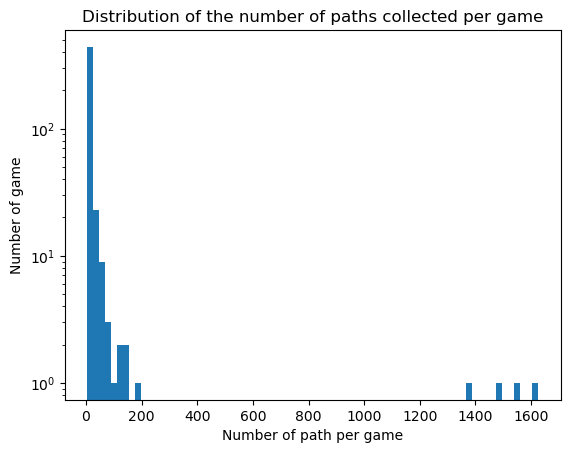

In [ ]:
# NEXTSTEP:: make it pretty
plt.hist(stats_games.tot_games_played, log=True, bins=75)
plt.xlabel('Number of path per game')
plt.ylabel('Number of game')
plt.title('Distribution of the number of paths collected per game')
stats_games.loc[stats_games.tot_games_played>500]

This method presents a drawback: most games have been played only a few times... We have to keep in ,mind that we are making statistics using only a few samples per game. The few games played a lot are the ones proposed by default by the website [1].

### 1.2.1) Shortest path and succes rate

Let's look at the shortest path and the success percentage of games to determine if there is a correlation.

In [ ]:
# First, we create a graph.
G_2007 = nx.DiGraph()
G_2007.add_nodes_from(np.unique(articles2007))
G_2007.add_edges_from(links2007[['linkSource', 'linkTarget']].to_numpy())

In [ ]:
# some stats about the links leading to target and shortest path
stats_games['links_to_target'] = stats_games.index.map(lambda x: links2007[['linkTarget', 'linkSource']].groupby('linkTarget').count().loc[x[1]].values[0])
stats_games['log_links_to_target'] = np.log(stats_games['links_to_target'])
stats_games['shortest_path'] = stats_games.apply(lambda x: len(nx.shortest_path(G_2007, source=x.name[0], target=x.name[1])), axis=1)
stats_games

finished  avg_f_path  std_f_path  \
start               target                                                     
14th_century        African_slave_trade            3    7.333333    2.081666   
                    Elizabeth_I_of_England         5    7.200000    5.019960   
                    Rainbow                       27    7.444444    3.630356   
1973_oil_crisis     Bohemian_Rhapsody              2    7.000000    0.000000   
19th_century        Lord_Voldemort                 2    9.500000    4.949747   
...                                              ...         ...         ...   
William_Shakespeare Television                     3    5.666667    1.154701   
Wolverine           Minimum_wage                   3   10.666667    9.291573   
World_Wide_Web      Color                          3    8.000000    4.358899   
Yak                 Harry_Potter                   2    5.500000    0.707107   
Zebra               Sassanid_Empire                3   10.333333    6.806859   

                                            sem_f_path  med_f_path  \
start               target                                           
14th_century        African_slave_trade       1.201850         8.0   
                    Elizabeth_I_of_England    2.244994         6.0   
                    Rainbow                   0.698662         7.0   
1973_oil_crisis     Bohemian_Rhapsody         0.000000         7.0   
19th_century        Lord_Voldemort            3.500000         9.5   
...                                                ...         ...   
William_Shakespeare Television                0.666667         5.0   
Wolverine           Minimum_wage              5.364492         8.0   
World_Wide_Web      Color                     2.516611         6.0   
Yak                 Harry_Potter              0.500000         5.5   
Zebra               Sassanid_Empire           3.929942         8.0   

                                            q25_f_path  q75_f_path  \
start               target                                           
14th_century        African_slave_trade           6.50        8.50   
                    Elizabeth_I_of_England        4.00        6.00   
                    Rainbow                       4.50        9.50   
1973_oil_crisis     Bohemian_Rhapsody             7.00        7.00   
19th_century        Lord_Voldemort                7.75       11.25   
...                                                ...         ...   
William_Shakespeare Television                    5.00        6.00   
Wolverine           Minimum_wage                  5.50       14.50   
World_Wide_Web      Color                         5.50        9.50   
Yak                 Harry_Potter                  5.25        5.75   
Zebra               Sassanid_Empire               6.50       13.00   

                                            q10_f_path  q90_f_path  \
start               target                                           
14th_century        African_slave_trade            5.6         8.8   
                    Elizabeth_I_of_England         4.0        12.0   
                    Rainbow                        4.0        13.4   
1973_oil_crisis     Bohemian_Rhapsody              7.0         7.0   
19th_century        Lord_Voldemort                 6.7        12.3   
...                                                ...         ...   
William_Shakespeare Television                     5.0         6.6   
Wolverine           Minimum_wage                   4.0        18.4   
World_Wide_Web      Color                          5.2        11.6   
Yak                 Harry_Potter                   5.1         5.9   
Zebra               Sassanid_Empire                5.6        16.0   

                                            min_f_path  ...  q75_unf_path  \
start               target                              ...                 
14th_century        African_slave_trade              5  ...         10.50   
                    Elizabeth_I_of_Engl

Let's analyze further the "big" games, more than a certain number of times.

In [ ]:
num_games = 30
stats_big_games = stats_games.copy(deep=True).loc[stats_games['tot_games_played']>=num_games].sort_values(by='percentage_success')
stats_big_games.describe()

,finished,avg_f_path,std_f_path,sem_f_path,med_f_path,q25_f_path,q75_f_path,q10_f_path,q90_f_path,min_f_path,...,q75_unf_path,q10_unf_path,q90_unf_path,min_unf_path,max_unf_path,tot_games_played,percentage_success,links_to_target,log_links_to_target,shortest_path
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,...,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,141.216216,7.081198,3.188519,0.495529,6.175676,5.121622,7.918919,4.562162,10.448649,4.189189,...,6.925676,3.167568,9.410811,3.054054,18.162162,219.621622,72.869635,95.621622,3.889121,3.837838
std,277.813200,1.561428,1.845143,0.423583,1.292157,1.016567,2.142537,0.876658,3.064458,0.810961,...,1.608209,0.478455,2.852658,0.328798,13.885471,457.331047,14.067231,144.127519,1.166748,0.646078
min,11.000000,4.333333,1.028334,0.093487,4.000000,3.000000,5.000000,3.000000,5.000000,3.000000,...,4.000000,3.000000,5.000000,3.000000,5.000000,31.000000,35.483871,3.000000,1.098612,3.000000
25%,29.000000,5.787234,1.897772,0.200167,5.000000,5.000000,6.000000,4.000000,7.900000,4.000000,...,6.000000,3.000000,7.000000,3.000000,9.000000,38.000000,65.094340,21.000000,3.044522,3.000000
50%,40.000000,7.192982,3.019205,0.376897,6.000000,5.000000,8.000000,5.000000,11.000000,4.000000,...,7.000000,3.000000,9.200000,3.000000,16.000000,51.000000,74.193548,43.000000,3.761200,4.000000
75%,69.000000,8.196429,3.655631,0.649088,7.000000,6.000000,9.000000,5.000000,12.800000,5.000000,...,7.500000,3.000000,11.600000,3.000000,20.000000,106.000000,84.313725,126.000000,4.836282,4.000000
max,1043.000000,10.588235,10.531012,2.001945,10.000000,8.000000,15.000000,6.000000,18.800000,6.000000,...,11.000000,5.000000,18.000000,5.000000,67.000000,1625.000000,93.750000,751.000000,6.621406,5.000000


/tmp/ipykernel_225175/374582093.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot([stats_big_games['shortest_path'][i], stats_big_games['shortest_path'][i]], [y[i]-1, y[i]+gap+1], 'r--', label='Shortest path' if i==1 else '')


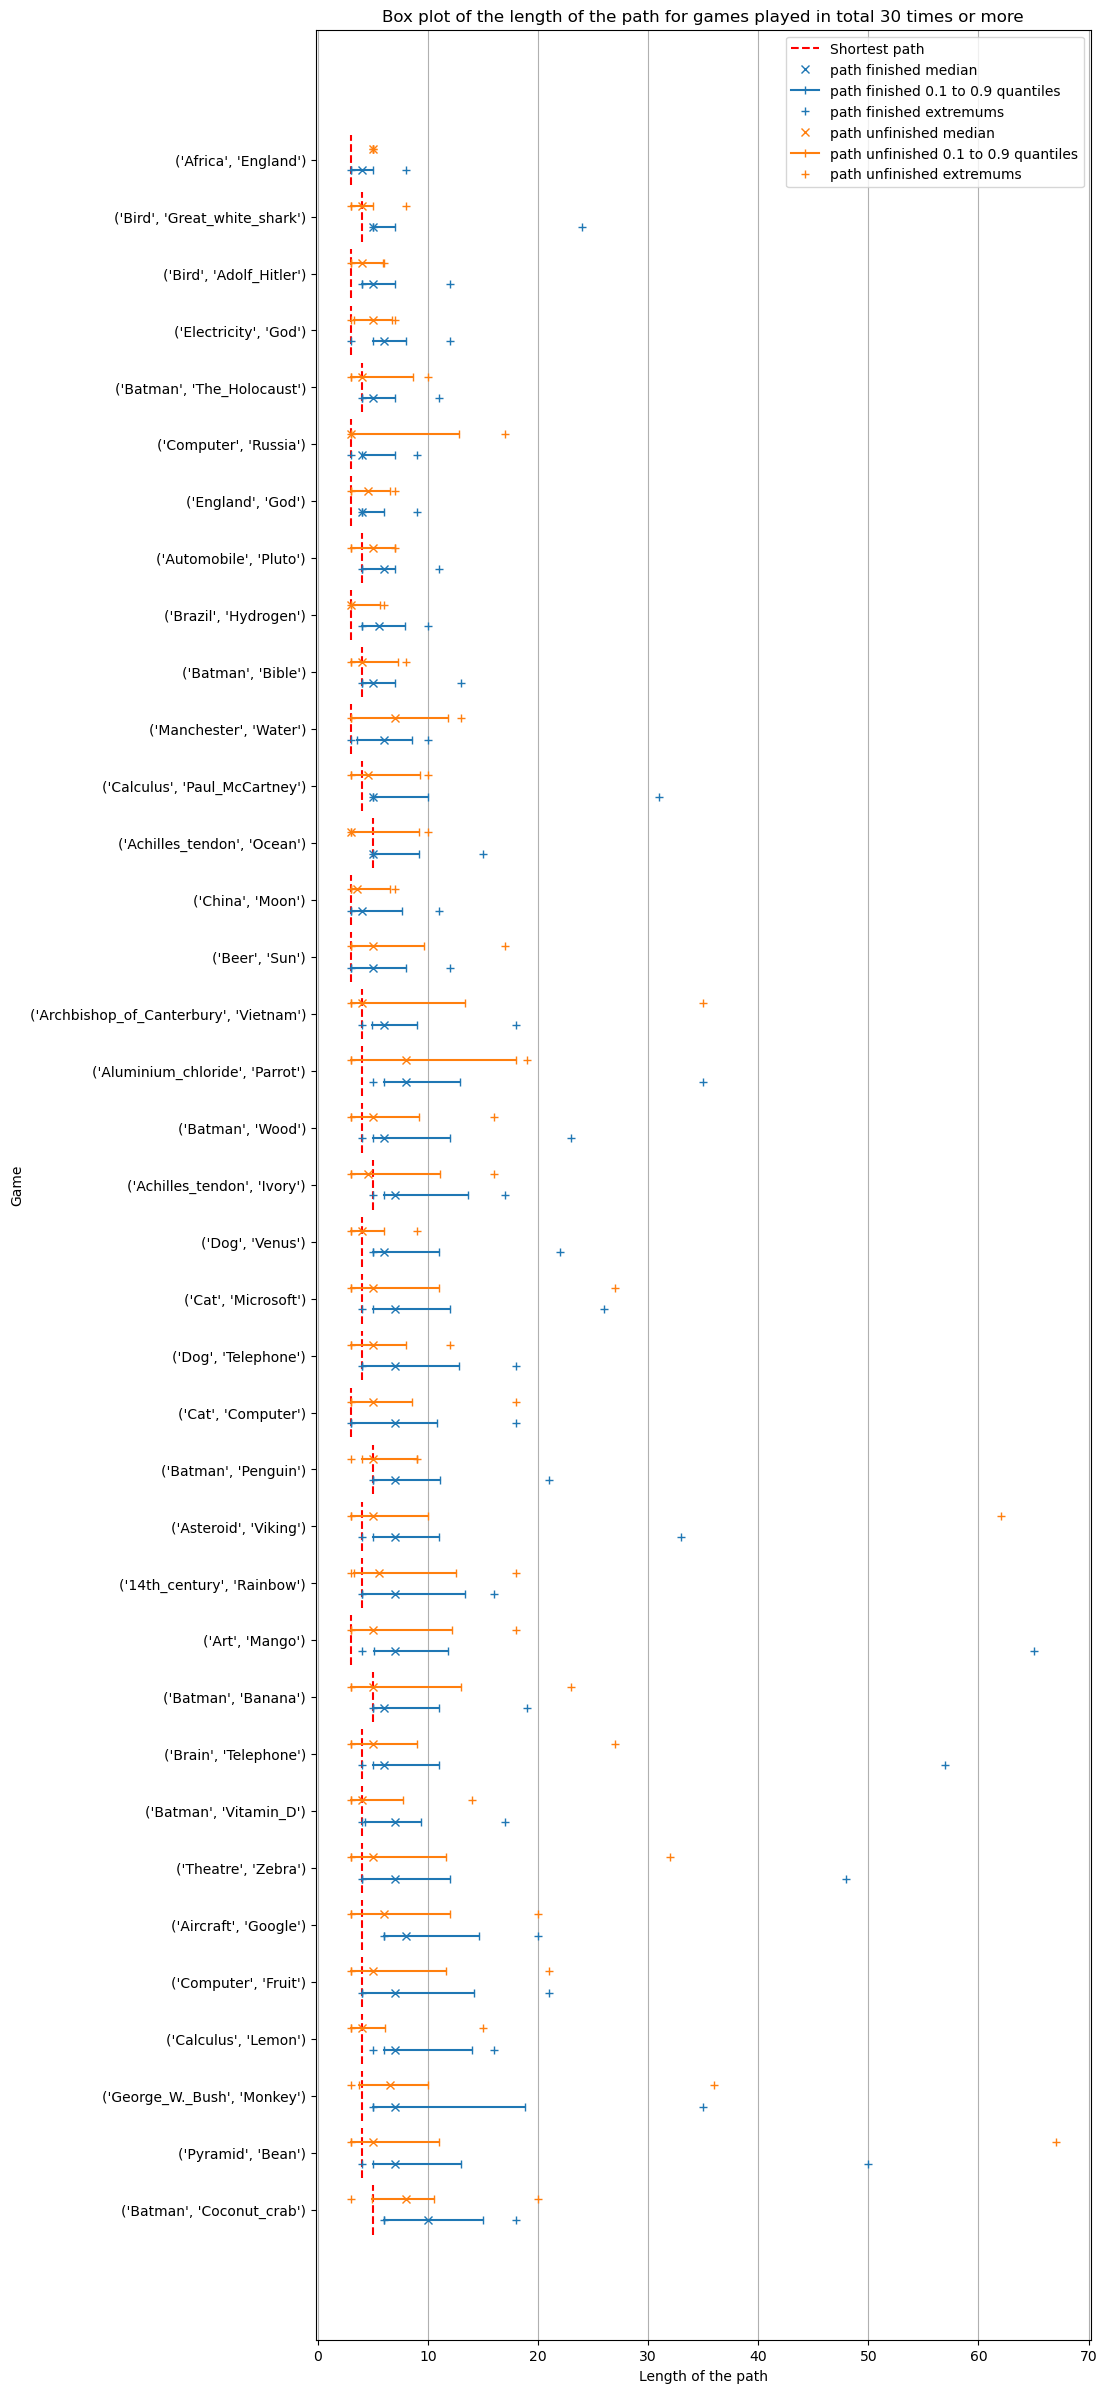

In [ ]:
# NEXTSTEP:: eventually create function in plotting.py for better encapsulation, make it pretty
# NEXTSTEP:: hypothesis testing to check if the length of the paths for a same game 
# depend if the path reach the target or not  

n = len(stats_big_games.index)
y = np.arange(int(n*4), step=4)
plt.figure(figsize=(10,30))
gap=1.5

for i in range(n):
    plt.plot([stats_big_games['shortest_path'][i], stats_big_games['shortest_path'][i]], [y[i]-1, y[i]+gap+1], 'r--', label='Shortest path' if i==1 else '')

# plt.errorbar(stats_big_games['avg_f_path'], y, xerr=stats_big_games['sem_f_path']*1.96/2,
#              linestyle='', marker='+', capsize=4, label='Finished', color='tab:blue')
plt.plot(stats_big_games['med_f_path'], y, 'x', color='tab:blue', label='path finished median')
plt.plot([stats_big_games['q10_f_path'], stats_big_games['q90_f_path']], [y, y], '-|', color='tab:blue', label='path finished 0.1 to 0.9 quantiles')
plt.plot(stats_big_games['min_f_path'], y, '+', color='tab:blue', label='path finished extremums')
plt.plot(stats_big_games['max_f_path'], y, '+', color='tab:blue')

plt.plot(stats_big_games['med_unf_path'], y+gap, 'x', color='tab:orange', label='path unfinished median')
plt.plot([stats_big_games['q10_unf_path'], stats_big_games['q90_unf_path']], [y+gap, y+gap], '-|', color='tab:orange', label='path unfinished 0.1 to 0.9 quantiles')
plt.plot(stats_big_games['min_unf_path'], y+gap, '+', color='tab:orange', label='path unfinished extremums')
plt.plot(stats_big_games['max_unf_path'], y+gap, '+', color='tab:orange')
# plt.errorbar(stats_big_games['avg_unf_path'], y+1.5, xerr=stats_big_games['sem_unf_path']*1.96/2,
#              linestyle='', marker='+', capsize=4, label='Unfinished', color='tab:orange')

plt.title(f'Box plot of the length of the path for games played in total {num_games} times or more')
plt.yticks(y+0.75, stats_big_games.index)
plt.grid(axis='x')
plt.xlabel('Length of the path')
plt.ylabel('Game')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

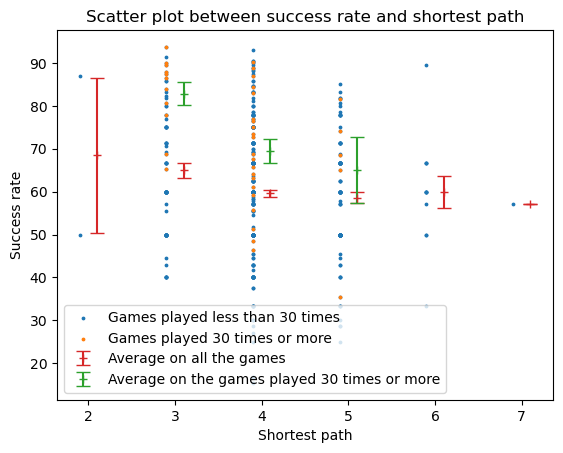

In [ ]:
# NEXTSTEP:: eventually create function in plotting.py for better encapsulation

ms=3; cp=5; gap=0.1
plt.scatter(stats_games['shortest_path']-gap, stats_games['percentage_success'], s=ms, label=f'Games played less than {num_games} times')
plt.scatter(stats_big_games['shortest_path']-gap, stats_big_games['percentage_success'], s=ms, label=f'Games played {num_games} times or more')

plt.errorbar(np.arange(stats_games['shortest_path'].min(), stats_games['shortest_path'].max()+1)+gap, 
             stats_games[['percentage_success', 'shortest_path']].groupby('shortest_path').mean().values.flatten(), 
             yerr=stats_games[['percentage_success', 'shortest_path']].groupby('shortest_path').sem().fillna(0).values.flatten()*1.96/2, 
             linestyle='', marker='+', markersize=ms*2, capsize=cp, color='tab:red', label='Average on all the games')

plt.errorbar(np.arange(stats_big_games['shortest_path'].min(), stats_big_games['shortest_path'].max()+1)+gap,
             stats_big_games[['percentage_success', 'shortest_path']].groupby('shortest_path').mean().values.flatten(),
             yerr=stats_big_games[['percentage_success', 'shortest_path']].groupby('shortest_path').sem().fillna(0).values.flatten()*1.96/2,
             linestyle='', marker='+', markersize=ms*2, capsize=cp, color='tab:green', label=f'Average on the games played {num_games} times or more')

plt.xlabel('Shortest path')
plt.ylabel('Success rate')
plt.title('Scatter plot between success rate and shortest path')
plt.legend();

In the following, some linear regression have been done but further data analysis must be conducted (hypothesis testing + regression).

In [ ]:
from sklearn.linear_model import LinearRegression

linReg = LinearRegression()
linReg.fit(np.arange(stats_games['shortest_path'].min(), stats_games['shortest_path'].max()+1).reshape(-1, 1), stats_games[['percentage_success', 'shortest_path']].groupby('shortest_path').mean().values.flatten())
linReg.coef_, linReg.intercept_

(array([-2.07176277]), 70.78647161959394)

In [ ]:
linReg = LinearRegression()
linReg.fit(np.arange(stats_big_games['shortest_path'].min(), stats_big_games['shortest_path'].max()+1).reshape(-1, 1), stats_big_games[['percentage_success', 'shortest_path']].groupby('shortest_path').mean().values.flatten())
linReg.coef_, linReg.intercept_

(array([-8.9321719]), 108.18415245279795)

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

mod_all = smf.ols(formula='percentage_success ~ shortest_path', data=stats_games)
mod_all.fit().summary()

mod_mean = smf.ols(formula='percentage_success ~ shortest_path', data=stats_games[['percentage_success', 'shortest_path']].groupby('shortest_path').mean().reset_index())
mod_mean.fit().summary()

mod_big_mean = smf.ols(formula='percentage_success ~ shortest_path', data=stats_big_games[['percentage_success', 'shortest_path']].groupby('shortest_path').mean().reset_index())
mod_big_mean.fit().summary()


/bin/anaconda3/envs/ada/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/bin/anaconda3/envs/ada/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     percentage_success   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     12.28
Date:                Fri, 15 Nov 2024   Prob (F-statistic):              0.177
Time:                        18:21:02   Log-Likelihood:                -6.4561
No. Observations:                   3   AIC:                             16.91
Df Residuals:                       1   BIC:                             15.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       108.1842     10.408     10.395      0.061     -24.059     240.427
shortest_path    -8.9322      2.549     -3.504      0.177     -41.325      23.461
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.000
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.531
Skew:                          -0.707   Prob(JB):                        0.767
Kurtosis:                       1.500   Cond. No.                         21.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 1.2.2) Success rate and number of links to the target article
It seems natural that the more links lead to the target article, the easier is the game. Let's check this hypothesis.

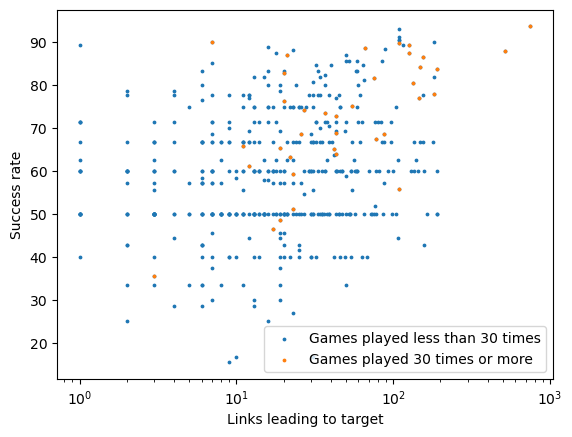

In [ ]:

ms=3; cp=5; gap=0.1
plt.scatter(stats_games['links_to_target'], stats_games['percentage_success'], s=ms, label=f'Games played less than {num_games} times')
plt.scatter(stats_big_games['links_to_target'], stats_big_games['percentage_success'], s=ms, label=f'Games played {num_games} times or more')

plt.xlabel('Links leading to target')
plt.ylabel('Success rate')
plt.xscale('log')
plt.legend()

In the following, we explore the link between shortest path and success rate. A few linear regression have been done so far but further data analysis must be conduct.

In [ ]:
mod_big = smf.ols(formula='percentage_success ~ log_links_to_target', data=stats_big_games)
mod_big.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     percentage_success   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     20.45
Date:                Fri, 15 Nov 2024   Prob (F-statistic):           6.73e-05
Time:                        18:21:02   Log-Likelihood:                -141.30
No. Observations:                  37   AIC:                             286.6
Df Residuals:                      35   BIC:                             289.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              44.3932      6.567      6.760      0.000      31.062      57.725
log_links_to_target     7.3221      1.619      4.522      0.000       4.035      10.609
==============================================================================
Omnibus:                        2.305   Durbin-Watson:                   0.805
Prob(Omnibus):                  0.316   Jarque-Bera (JB):                1.213
Skew:                           0.315   Prob(JB):                        0.545
Kurtosis:                       3.625   Cond. No.                         15.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 1.2.3) Combining the predictors
In this section we plan to find a model that combine the number of links to target and the shortest path. We might add other predictors not studied yet.

## Part 2 : Wikipedia evolution between 2007 and 2024

### 2.0) About the subset of articles used in the game

In this part, we investigate the evolution of Wikipedia between 2007 and 2024. To do so, we compare the structures and versions of the 4600 articles that were selected in the 2007 Wikispeedia dataset at both time points. The subselection of articles was done by the creators of the game Wikispeedia [1], [2]. 


#### Loading the raw scrapping of Wikipedia 2024

To compare Wikipedia structure between 2007 and 2024 we first had to retrieve the content of the current Wikipedia database. We scrapped the 4604 equivalent articles of Wikispeedia by referring by their names. The details of this step can be found in ```scrapping.ipynb```.


In [32]:
from src.scripts.loading_data import *

# importing articles names and links
raw_articles2007, raw_links2007 = loading_articles_links('2007', raw = True)
raw_articles2024, raw_links2024 = loading_articles_links('2024', raw = True)

In [33]:
# checking the sizes 
print('Number of articles in 2007 :',len(raw_articles2007)) 
print('Number of articles in 2024 :',len(raw_articles2024))
print('Number of links in 2007 :', raw_links2007.shape[0]) 
print('Number of links in 2024 :',raw_links2024.shape[0])

Number of articles in 2007 : 4604
Number of articles in 2024 : 4592
Number of links in 2007 : 119882
Number of links in 2024 : 224054


Interstingly, by scrapping the corresponding articles, we miss 11 articles. Let us investigate on which articles we are missing these particular articles in 2024 and why did their scrapping  fail.

#### From eleven missing articles to only four

When retrieving 2024 Wikipedia articles, for eleven article names the corresponding URL did not exist anymore in 2024. For seven of them we could find the equivalent page on Wikipedia 2024 with a slightly different name. The corresponding URL to the new page is provided in brakets, along with the new name. However for four of them no evident equivalent page culd be found. This leads us to think that these four specific pages have been removed from Wikipedia between 2007 and 2024.

- Athletics_(track_and_field) (https://en.wikipedia.org/wiki/Track_and_field, Track_and_field)
- Bionicle__Mask_of_Light (https://en.wikipedia.org/wiki/Bionicle:_Mask_of_Light, Bionicle:_Mask_of_Light)
- Directdebit (https://en.wikipedia.org/wiki/Direct_debit, Direct_debit)
- Friend_Directdebit (-)
- Gallery_of_the_Kings_and_Queens_of_England (-)
- Newshounds (https://en.wikipedia.org/wiki/News_Hounds, News_Hounds)
- Sponsorship_Directdebit (-)
- Star_Wars_Episode_IV__A_New_Hope (https://en.wikipedia.org/wiki/Star_Wars_(film), Star_Wars_(film))
- Wikipedia_Text_of_the_GNU_Free_Documentation_License (https://en.wikipedia.org/wiki/Wikipedia:Text_of_the_GNU_Free_Documentation_License, Wikipedia:Text_of_the_GNU_Free_Documentation_License)
- Wowpurchase (-)
- X-Men__The_Last_Stand (https://en.wikipedia.org/wiki/X-Men:_The_Last_Stand, X-Men:_The_Last_Stand)

We manually added the seven newly named articles back to the dataframe of 2024 articles, by referring to them with their previous name, for comparability.
To investigate a bit more the four missing pages, let us look at their plain text articles, provided by Wikispeedia.

In [34]:
os.getcwd()

'/home/julia/files/EPFLph/MA3/ADA/project/ada-2024-project-outlier-1'

In [35]:
# define path to the data
PLAIN_TEXT_PATH = 'data/2007/plain_text_articles/'

# extract the plain text articles from 2007
Friend_Directdebit = open(os.path.join(PLAIN_TEXT_PATH, 'Friend_Directdebit.txt')).read()
Gallery_of_the_Kings_and_Queens_of_England = open(os.path.join(PLAIN_TEXT_PATH, 'Gallery_of_the_Kings_and_Queens_of_England.txt')).read()
Sponsorship_Directdebit = open(os.path.join(PLAIN_TEXT_PATH, 'Sponsorship_Directdebit.txt')).read()
Wowpurchase = open(os.path.join(PLAIN_TEXT_PATH, 'Wowpurchase.txt')).read()

In [36]:
print(Friend_Directdebit)

                             [1x1.gif] [1x1.gif]


   [Direct_Debit.gif]

Become an SOS Friend - Direct Debit


   Thank you for taking a moment to complete this simple form, and for
   helping us help orphaned and abandoned children around the world.

   The minimum donation for an SOS friend is £10/month. If you cannot
   afford this, please use this link to making a smaller regular donation.

   All the normal Direct Debit safeguards and guarantees apply. No changes
   in the amount, date or frequency to be debited can be made without
   notifying you at least 10 working days in advance of your accounts
   being debited. In the event of any error, you are entitled to an
   immediate refund from your Bank or Building Society. You have the right
   to cancel a Direct Debit Instruction at any time simply by writing to
   your Bank or Building Society, with a copy to us.

   Any questions?
   If you have any queries, or would like to make a Direct Debit Donation
   over the phone, pleas

In [37]:
print(Gallery_of_the_Kings_and_Queens_of_England)

   #copyright

Gallery of the Kings and Queens of England

2007 Schools Wikipedia Selection. Related subjects: British History

   This is a gallery of the Kings and Queens of England.

House of Wessex

                         Alfred the Great (871-899)

                         Edward the Elder (899-924)

                               Ælfweard (924)

       Athelstan (924-939)The first de facto King of a unified England

                             Edmund I (939-946)

                               Edred (946-955)

                           Edwy the Fair (955-959)

                               Edgar (959-975)

                       St Edward the Martyr (975-978)

                 Ethelred the Unready (978-1013, 1014-1016)

                         Sweyn Forkbeard (1013-1014)

                           Edmund Ironside (1016)

                             Canute (1016-1035)

                         Harold Harefoot (1035-1040)

                          Harthacanute (1040-1042)


In [38]:
print(Sponsorship_Directdebit)

                             [1x1.gif] [1x1.gif]


   [Direct_Debit.gif]

Sponsor a Child with SOS Children - Direct Debit


   Thank you for taking a moment to complete this simple form, and for
   helping us help orphaned and abandoned children around the world.

   The minimum donation for child sponsorship is £20/month. If you cannot
   afford this, please consider making a smaller regular donation. Use one
   of these links: you can become an SOS friend for a minimum of £10 per
   month or make a regular donation for a minimum of £5 per month.

   All the normal Direct Debit safeguards and guarantees apply. No changes
   in the amount, date or frequency to be debited can be made without
   notifying you at least 10 working days in advance of your accounts
   being debited. In the event of any error, you are entitled to an
   immediate refund from your Bank or Building Society. You have the right
   to cancel a Direct Debit Instruction at any time simply by writing to
   your Bank 

In [39]:
print(Wowpurchase)

                             [1x1.gif] [1x1.gif]


Buy WOW wrist bands
to support SOS Children


   You can purchase WOW Wristbands from this page.
   You will need a debit or credit card to pay for them.
   If you don't have a card, please place your order by post.

   The wrist bands cost £1 each.

   Postage is 50p for up to 5 bands, £1 for 6 to 20 bands,
   £1.50 for 21 to 50 bands and £2 for 51 to 1000 bands.
   Number of wrist bands: _____
   Proceed to Purchase

                           SOS Children's Villages
                            WOW wrist band detail

   SOS Children refers to the worldwide work of SOS-KDI and is a trading
   name for SOS Children's Villages UK

   For further information about our work please see our children charity
   web site or sponsoring a child.

   Charity Commission registered number 1069204

   [1x1.gif] [1x1.gif]



Interestingly, it seems like the three articles DirectDebit, SponsorshipDebit and Wowpurchase are not articles but foundraise forms. It is probable that since this kind of page does not respect Wikipedia's policy, they were removed from the plateform. Wikispeedia players could however go to these pages and click on their links if they wanted to. Lastly, it is not sure why Gallery_of_the_Kings_and_Queens_of_England was removed from wikipedia, it is probable that this subject was restructured into several pages for each of the royal family, which is why we cannot find one single equivalent page in 2024.

For the rest of our study, we will let these four article in 2007 without matching article in 2024. However, we will probably have to remove them from some visualizations when matching dimensions between the two datasets will be needed.

#### Re-importing 2024 articles
As seen in the previous part, we were able to identify seven articles present in 2007 that we missed when importing their equivalent of 2024 because of a name change. In ```scrapping.ipynb``` we rescrapped all 2024 articles's links with the seven additional articles and their actual name. From now on, we will use this new dataset for the rest of our analysis.

In [40]:
# importing articles names and links
articles2007, links2007 = loading_articles_links('2007')
articles2024, links2024 = loading_articles_links('2024')

We now would like to take a look at the links we imported. Some source articles had no targets in 2007 but do have new targets in 2024. The other way around is also possible: 2007 target articles may have change so drasticly that no link exist anymore in 2024. We will thus look at the articles that are not present as source articles in 2007 vs in 2024.

In [41]:
source_articles2007 = set(links2007.linkSource.drop_duplicates().reset_index(drop = True))
source_articles2024 = set(links2024.linkSource.drop_duplicates().reset_index(drop = True))

print(len(source_articles2007), len(source_articles2024))

4587 4551


In [42]:
not_in_2007 = source_articles2024 - source_articles2007
not_in_2024 = source_articles2007 - source_articles2024

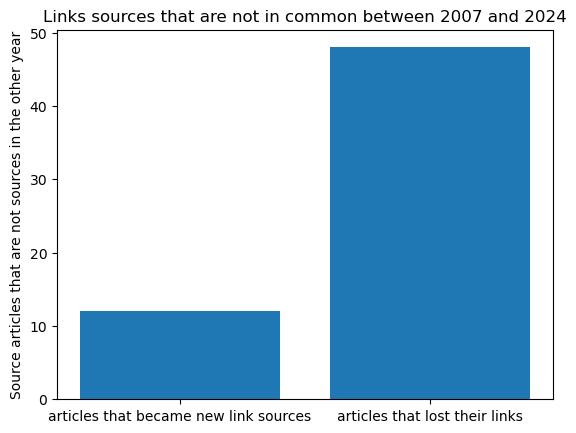

In [43]:
plt.bar(x=['articles that became new link sources','articles that lost their links'], height=[len(not_in_2007), len(not_in_2024)])
plt.title('Links sources that are not in common between 2007 and 2024')
plt.ylabel("Source articles that are not sources in the other year")
plt.show()

What we observe from comparing the links contained in the articles in the different years : 
- 48 articles have no links redirecting from them in 2024 
- 12 articles have links in 2024 while they had none in 2007

To investigate the cause of this for the 48 missing links articles in 2024, we compared their wikipedia page from the game versus their actual page in 2024 for a few of them taken at random. What happened for them is the following : 
- for 4 articles : as we saw previously, they have been deleted in wikipedia 2024. 3 of them corresponded to fake wiki pages for a donation and one was named Gallery_of_Kings_and_Queens_of_England and was probably reformated and fused to another article that completely changed their name. 
- for the rest of the articles : in 2007, as wikipedia was smaller in general, the articles names were more vague. For example Battle_of_Amiens in 2007 corresponded to the battle that occured in 1918 only. In 2024, the article Battle_of_Amiens is now a Disambigation Page, meaning the title 'Battle_of_Amiens' may refer to multiple different wikipedia pages that carry the same title. If we observe the current page of this article in 2024, it has 3 different links that redirect to pages not included in our restricted 4604 articles database : Siege of Amiens (1597), Battle of Amiens (1870) and finally the Battle of Amiens (1918) that is the one in the 2007 dataset. 

Following this, it would be interesting to check how many of those 48 pages actually carry the 'Disambiguation Page' function in 2024 to validate our hypothesis that this is why this happens. Ideally we could then rescrapp the correct pages of 2024 that do really correspond to their equivalent in 2007. This would modify the number of links on average in 2024, and thus the shortest path matrix that we compute later on. 

Please note that this disambiguouation part of our project is still going on. We however continued our analysis to build a strong pipeline while waiting for the total cleaning of 2024 data. We will have to reperform our analysis afterwards.

### 2.1) Loading the clean data

In [44]:
# importing articles names and links
articles2007, links2007 = loading_articles_links('2007')
articles2024, links2024 = loading_articles_links('2024')

# checking the sizes 
print('2007 :',len(articles2007)) 
print('2024 :',len(articles2024))

2007 : 4604
2024 : 4604


As mentionned above in part 0, some articles have been deleted between 2007 and 2024. So the list of articles of 2024 does not contain them and there are no links redirecting to them in the links2024 file. However we retrieved the articles whose names have been modified and kept the name for 2007 to refer to them in the 2024 list. 

### 2.2) Comparing the Hyperlinks Structure 

As a first analysis to justify our project we compare the two wikipedia version structures. 

T test p value : [6.91824887e-191]


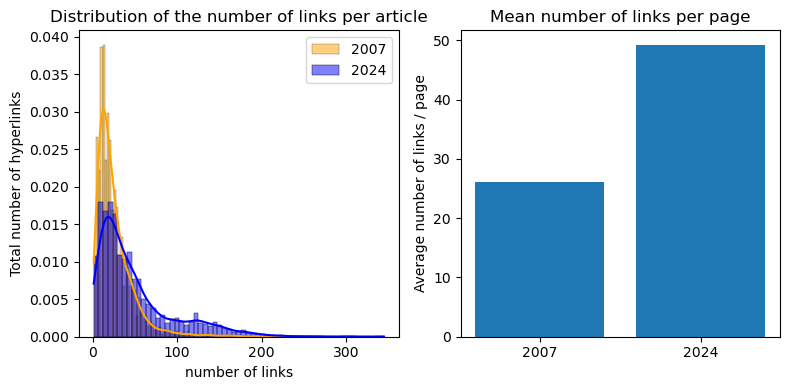

In [45]:
from src.scripts.plotting import *

plot_average_links_per_page(links2007, links2024)

The two distributions seem different, as already observed. In global there are more links per pages on average in 2024 than in 2007, as this is confirmed by our independent T test p value of 6.9e-191, this difference is statistically significative. When looking a the distributions we also see that the 2024 one has more articles with a higher number of links and also less articles with a small number of links. 

/home/julia/files/EPFLph/MA3/ADA/project/ada-2024-project-outlier-1/src/scripts/plotting.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x= difference.index, y = difference, palette= colors)


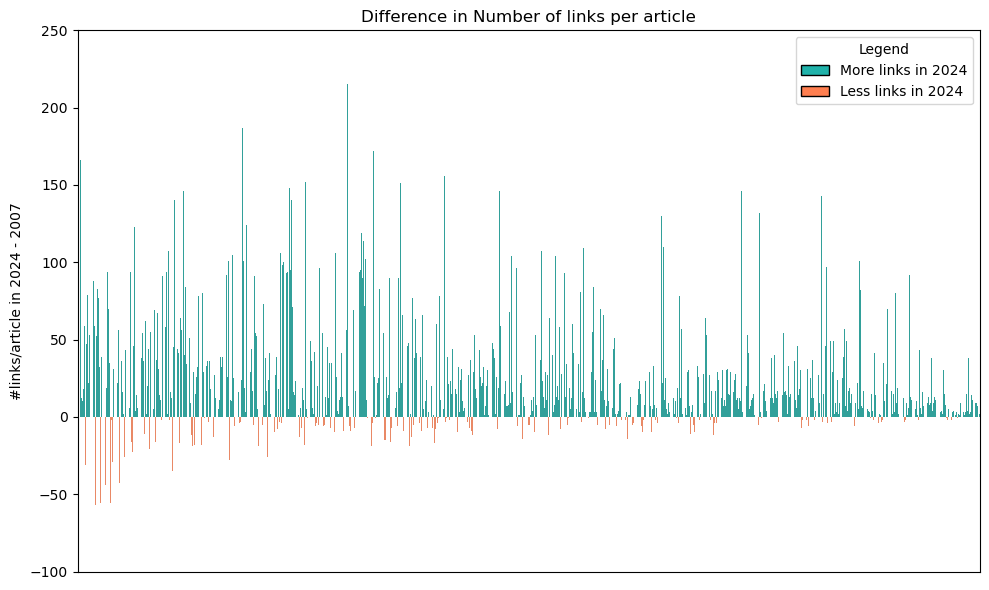

In [46]:
plot_difference_links_article(links2007, links2024)

Here we look more closely at each article, to see how the number of links per page evolved. Everything above zero represent a positive difference between the number of links in 2024 minus the number in 2007 so this relates to when 2024 has more links than 2007, and everything below will thus correspond to 2024 having less links than in 2007. Visually we can already see that there tends to be more links in 2024 than in 2007 for the same article. 

### 2.3) Shortest Paths comparison

As a metric to how connected the two wikipedia are, we also look into the shortest path amtrix for the both of them. They are computed using the Floyd Warshall algorithms. We verified that the function used, from the networkx package, produced the exact same matrix for the 2007 data in the exploratory notebook. 

In [ ]:
### creating Graphs 
G_2007 = creating_graph(links2007, articles2007)
G_2024 = creating_graph(links2024, articles2007)
# here we use the list of articles from 2007 as it has all the nodes
# whereas some are missing in the 2024 list as stated earlier 
# it is important to create all the nodes even if we don't have any link 
# that connects them to the other, in order to generate the difference map later
# so that the two spm have the same dimensions

### computing shortest path matrices (spm)
# this step takes approx 15 min
spm_2007 = computing_shortest_path_matrix(G_2007, articles2007)
spm_2024 = computing_shortest_path_matrix(G_2024, articles2007)

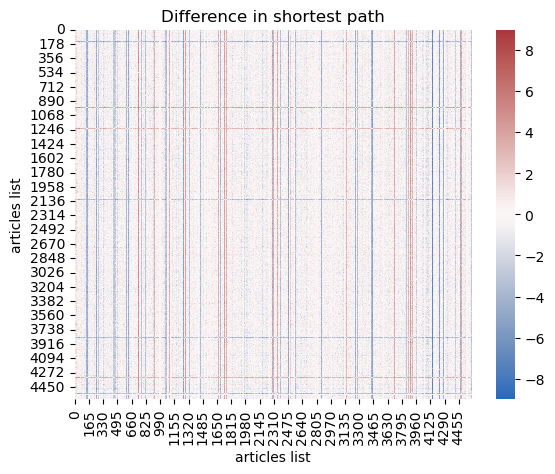

In [ ]:
plotting_difference_heatmap(spm_2007,spm_2024)

Similarly, in this heatmap we substract the Shortest Path Matrix of 2024 minus the one of 2007. This way any point corresponding to a red value means the path from the two articles is shorter in 2024, while blue means the path in 2024 is longer than in 2007

## Part 3 : Performance of the players depending on the year

## Part 4 : LLM performance on different versions

In this part of the notebook we will use games played by **mistral 7B** and **llama3 8B** in 2007 and 2024 to compare the evolution of the LLM over time.

We used [ollama](https://ollama.com/) docker container version to used LLMs models (see `SETUP.md` for installations instructions). for the prompt used to generate the games, we used the following prompt (inspired by the prompt used [Human vs IA](https://drudilorenzo.github.io/ada-klech-data-story/)):

First we give the context of the game to the llm:

*We now play the following game:*

*I will give you a target word and a list from which you can choose an option. If the available options contains the target word, you choose it. Otherwise you choose the option that is most similar to it. Before starting, I give you one examples, then it's your turn:*

*you need to follow the same format as the example below:
Target word: George_Washington*

*Available options: [Able_Archer_83, Afghanistan, , Estonia, Europe, Finland, France, French_language, George_W._Bush, Hungary, September_11,_2001_attacks, United_States]*

*Reasoning: I need to find something inside the list related to the target: 'George_Washington'. George Washington was the first president of United States and he lived in United States.*

*Answer: Hence the answer is: 'United_States'.*


Then we give the llm the target word and the list of options:

*I will give you a target word and a list from which you can choose an option. If the available options contains the target word, you choose it. Otherwise you choose the option that is most similar to it* 

*Target word: [{target}]*

*Available options: [{links}]*

*RESPECT THIS FORMAT WHEN ANSWERING:*

*Reasoning: [REASONING]*

*Answer: Hence the choice is: '[ANSWER]'*


We will repeat this prompt with the new available options until the llm finds the target word or the prompt reaches 100 iterations.

Loading players games data on 2007 and LLMs (mistral, llama3) games data for 2007 and 2024


In [ ]:
# Load data

## llama3 8B
llama3_2007 = pd.read_csv(DATA + "llama3/llm_paths.csv",index_col=['start', 'end'])
llama3_2024 = pd.read_csv(DATA + "llama3/llm_paths2024.csv",index_col=['start', 'end'])

## mistral 7B
mistral_2007 = pd.read_csv(DATA + "mistral/llm_paths.csv",index_col=['start', 'end'])
mistral_2024 = pd.read_csv(DATA + "mistral/llm_paths2024.csv",index_col=['start', 'end'])

## Player 2007
players_2007 = pd.read_csv(DATA + "wikispeedia_paths-and-graph/paths_finished.tsv",sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])

In [ ]:
players_2007=process_player_path_data(players_2007)

### Compare LLMs with the players

**Warning** : At the moment we should be critical about the results, because the llms only played each game once. In the future, we will have several games to compare in order to increase the confidence in the results.

The goal of this section is to compare the performance of the LLMs with the players in 2007 in order to see which LLMs seems to perform like the players in 2007.



Text(0.5, 1.0, 'Number of paths not found by model and year among 213 games')

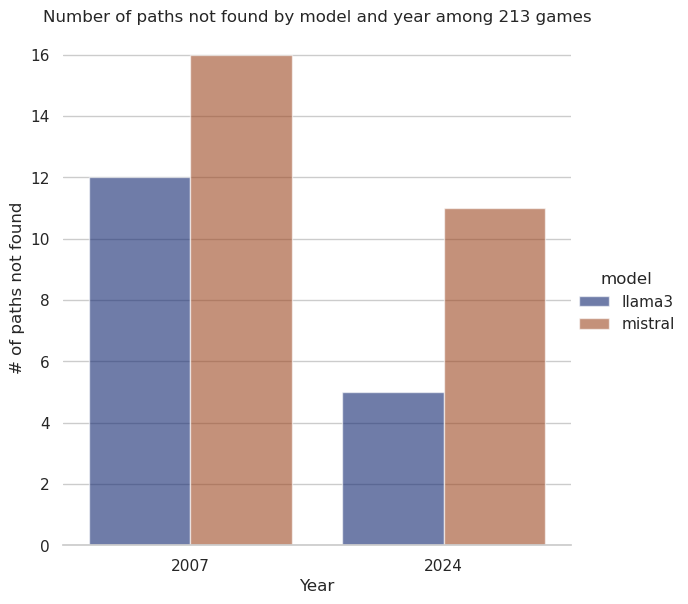

In [ ]:
## count null paths for all model
llama3_2007_null = llama3_2007["path"].isnull().sum()
llama3_2024_null = llama3_2024["path"].isnull().sum()
mistral_2007_null = mistral_2007["path"].isnull().sum()
mistral_2024_null = mistral_2024["path"].isnull().sum()

null_paths = pd.DataFrame({ "model": ["llama3", "llama3", "mistral", "mistral"], "year": [2007, 2024, 2007, 2024], "null_paths": [llama3_2007_null, llama3_2024_null, mistral_2007_null, mistral_2024_null]})

sns.set_theme(style="whitegrid")
g = sns.catplot(x="year", y="null_paths", hue="model", data=null_paths, kind="bar", height=6, alpha=.6, palette="dark",errorbar="sd")
g.despine(left=True)
g.set_axis_labels("Year", "# of paths not found")
plt.title("Number of paths not found by model and year among 213 games")

On the bar plot above, we can observe that mistral struggled more to find paths than llama3 within 100 prompts. 

This result should be treated with coution because the LLMs only played each game once. In the future, we will have several games to compare in order to increase the confidence in the results.

Data processing :

- Remove the games that the llms did not finish
- Process path given by the llms by removing periodic loops, consecutive duplicates, cut the list to the first occurence of the target word.
- Compute the length of the path
- Compute basic statistics on the length of the path for each llm and player

In [ ]:
# drop null paths
llama3_2007 = llama3_2007.dropna()
llama3_2024 = llama3_2024.dropna()
mistral_2007 = mistral_2007.dropna()
mistral_2024 = mistral_2024.dropna()

# transform path str(list) to list
llama3_2007["path"] = llama3_2007["path"].apply(lambda x: x[1:-1].replace("'", "").replace(" ", "").split(','))
llama3_2024["path"] = llama3_2024["path"].apply(lambda x: x[1:-1].replace("'", "").replace(" ", "").split(','))
mistral_2007["path"] = mistral_2007["path"].apply(lambda x: x[1:-1].replace("'", "").replace(" ", "").split(','))
mistral_2024["path"] = mistral_2024["path"].apply(lambda x: x[1:-1].replace("'", "").replace(" ", "").split(','))

In [ ]:
# Post processing on paths 
llama3_2007["path"] = llama3_2007["path"].apply(post_processing)
llama3_2024["path"] = llama3_2024["path"].apply(post_processing)
mistral_2007["path"] = mistral_2007["path"].apply(post_processing)
mistral_2024["path"] = mistral_2024["path"].apply(post_processing)

In [ ]:
llama3_2007["length"] = llama3_2007["path"].apply(len)
llama3_2024["length"] = llama3_2024["path"].apply(len)
mistral_2007["length"] = mistral_2007["path"].apply(len)
mistral_2024["length"] = mistral_2024["path"].apply(len)

In [ ]:
# Compute the average length of the path for each model
avglen = pd.DataFrame(players_2007["length"].groupby(by=['start', 'end']).agg(['mean', 'std', 'median', 'count']))
avglen = pd.merge(avglen, llama3_2007['length'], left_index=True, right_index=True)
avglen = avglen.rename(columns={'length':'llama3_2007'})
avglen = pd.merge(avglen, llama3_2024['length'], left_index=True, right_index=True)
avglen = avglen.rename(columns={'length':'llama3_2024'})
avglen = pd.merge(avglen, mistral_2007['length'], left_index=True, right_index=True)
avglen = avglen.rename(columns={'length':'mistral_2007'})
avglen = pd.merge(avglen, mistral_2024['length'], left_index=True, right_index=True)
avglen = avglen.rename(columns={'length':'mistral_2024'})

In [ ]:
avglen.reset_index(inplace=True)

In [ ]:
generate_performance_scatter(avglen)

Llama3 seems to fall more often in the confidence interval of the players in 2007 than mistral. Let's see this in more detail below.


Number of LLM games in CI from player games: 66.66666666666666%
Number of Mistral games in CI from player games: 59.42028985507246%


Text(0.5, 1.0, 'Percentage of games in CI from player games')

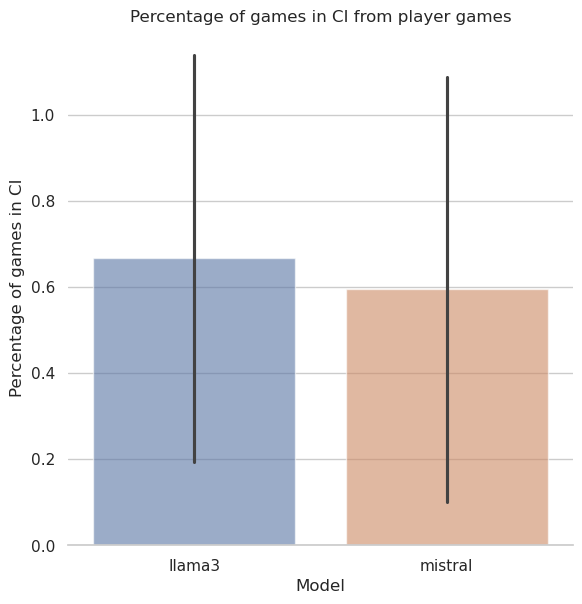

In [ ]:
avglen['llama3_2007_in_CI'] = avglen.apply(lambda x: check_if_in_CI(x,'llama3_2007'), axis=1)
avglen["mistral_2007_in_CI"] = avglen.apply(lambda x: check_if_in_CI(x,'mistral_2007'), axis=1)
print(f'Number of LLM games in CI from player games: {avglen.llama3_2007_in_CI.mean()*100}%')
print(f'Number of Mistral games in CI from player games: {avglen.mistral_2007_in_CI.mean()*100}%')

# plot the number of games in CI
tmp_llama3 = avglen["llama3_2007_in_CI"].rename("in_CI").to_frame()
tmp_llama3["model"] = "llama3"
tmp_mistral = avglen["mistral_2007_in_CI"].rename("in_CI").to_frame()
tmp_mistral["model"] = "mistral"

ci_model = pd.concat([tmp_llama3, tmp_mistral])

sns.set_theme(style="whitegrid")
g = sns.catplot(x="model", y="in_CI", hue="model", data=ci_model, kind="bar", height=6, alpha=.6,errorbar="sd")
g.despine(left=True)
g.set_axis_labels("Model", "Percentage of games in CI")
plt.title("Percentage of games in CI from player games")

Indeed, llama3 fall in 66.67% of the games in the confidence interval of the players in 2007, while mistral only fall in 59.42% of the games in the confidence interval of the players in 2007. 

But does llama3 take similar paths to the players in 2007 ? 

let's check that with the jaccard similarity of the article title in the next section.

This result should be treated with coution because the LLMs only played each game once. In the future, we will have several games to compare in order to increase the confidence in the results.

Jaccard similarity between player and llama3 2007: 0.27016937576944144
Jaccard similarity between player and mistral 2007: 0.32329015886677054


Text(0.5, 1.0, 'Jaccard similarity between player and model')

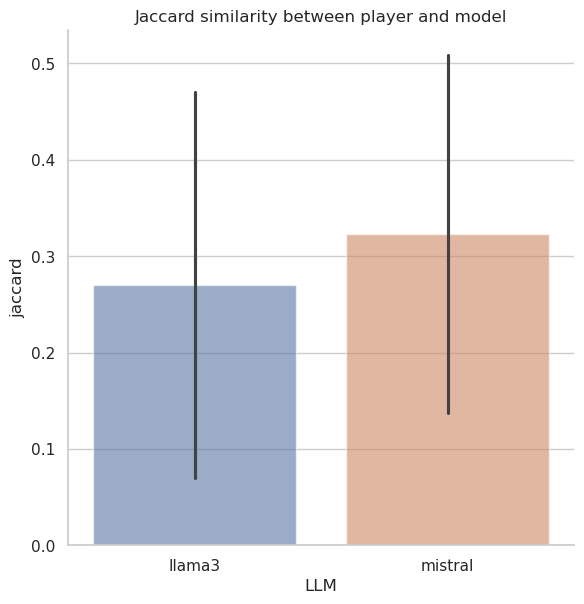

In [ ]:
# compute jaccard similarity between player and model
players_2007 = players_2007["path"].apply(fix_path) # removing '<' in the path
jaccard_llama3 = pd.merge(players_2007, llama3_2007, on=['start', 'end'], suffixes=('_x', '_y'))
jaccard_llama3['jaccard'] = jaccard_llama3.apply(jaccard_similarity, axis=1)
print(f'Jaccard similarity between player and llama3 2007: {jaccard_llama3["jaccard"].mean()}')

jaccard_mistral = pd.merge(players_2007, mistral_2007, on=['start', 'end'], suffixes=('_x', '_y'))
jaccard_mistral['jaccard'] = jaccard_mistral.apply(jaccard_similarity, axis=1)
print(f'Jaccard similarity between player and mistral 2007: {jaccard_mistral["jaccard"].mean()}')

jaccard_llama3["LLM"] = "llama3"
jaccard_mistral["LLM"] = "mistral"

jaccard = pd.concat([jaccard_llama3, jaccard_mistral])
sns.set_theme(style="whitegrid")
g = sns.catplot(x="LLM", y="jaccard", hue="LLM", data=jaccard, kind="bar", height=6, alpha=.6,errorbar="sd")
plt.title("Jaccard similarity between player and model")

The jaccard similarity between the paths of the players in 2007 and llama3 is 0.27, which is quite low. This means that llama3 does not take similar paths to the players in 2007. the similarity with mistral is slightly higher with 0.32 but still low.


In [ ]:
# T-Test Compare the means of path lengths (human vs. model)
ttest_llama3 = ttest_ind(avglen['llama3_2007'], avglen['mean'])
ttest_mistral = ttest_ind(avglen['mistral_2007'], avglen['mean'])
print(f'T-Test between player and llama3 2007: {ttest_llama3}')
print(f'T-Test between player and mistral 2007: {ttest_mistral}')

T-Test between player and llama3 2007: TtestResult(statistic=1.1748021910869217, pvalue=0.24109380717803772, df=274.0)
T-Test between player and mistral 2007: TtestResult(statistic=3.2286406525332207, pvalue=0.0013952013335809983, df=274.0)


The result of the T-Test between the paths length mean of the players in 2007 and llama3 is p-value = 0.2410. This means that we cannot reject the null hypothesis that the paths length mean of the players in 2007 and llama3 are equal.

the result of the T-Test between the paths length mean of the players in 2007 and mistral is p-value = 0.0014. This means that we can reject the null hypothesis that the paths length mean of the players in 2007 and mistral are equal.

### Compare the results of the LLMs on 2007 and 2024

Based on the previous results, we choose to compare the results of llama3 on 2007 and 2024.

**Warning** : At the moment we should be critical about the results, because the llms only played each game once. In the future, we will have several games to compare in order to increase the confidence in the results.



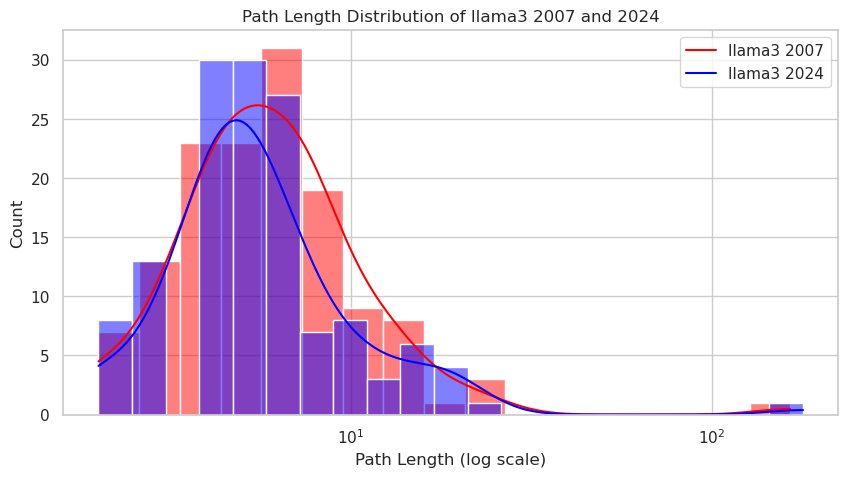

In [ ]:
# plot path length distribution of llama3 2007 and 2024
plot_path_length_distribution(avglen, 'llama3',log_scale=True)

The graph above show a similar distribution of the paths length between 2007 and 2024 for llama3. This means that llama3 does not seem to have evolved between 2007 and 2024.

Further analysis will be done in the future once we have more played games to compare.

# References


[1] Robert West and Jure Leskovec:
     Human Wayfinding in Information Networks.
     21st International World Wide Web Conference (WWW), 2012.
     
[2] Robert West, Joelle Pineau, and Doina Precup:
     Wikispeedia: An Online Game for Inferring Semantic Distances between Concepts.
     21st International Joint Conference on Artificial Intelligence (IJCAI), 2009.